## Imports

In [39]:
import numpy as np 
import pandas as pd
from PIL import Image
import random
import math

import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

## Loading and Preparing the Data

In [40]:
train_data = []
test_data = []
labels = []
subfolders = os.listdir('dataset-resized')
for subfolder_num in range(0, len(subfolders)):
    labels.append(subfolder_num)

print(labels)

for k in labels:
    data_path_k = "dataset-resized/" + subfolders[k] + "/"
    files = os.listdir(data_path_k)
    total_files = len(files)
    train_total = math.floor(total_files * 0.75)
    train_count = 0
    
    for file in files:
        im = Image.open(data_path_k + file)
        im_array = np.asarray(im) / 255.
        im_array = im_array.flatten()
        pixels = im_array.tolist()
        
        if (train_count < train_total):
            train_count += 1
            train_data += [(pixels, k)]
        else:
            test_data += [(pixels, k)]
    print(len(train_data))
    print(len(test_data))
        
random.shuffle(train_data)
random.shuffle(test_data)

[0, 1, 2, 3, 4, 5]
130
44
269
91
409
138
553
186
693
233
795
268


## Defining the Model

In [41]:
def get_size(dataset):
    return len(dataset)

def get_samples(dataset, batch):
    return random.sample(dataset, batch)

def compute_average_accuracy(dataset, model, step = 1):
    x, y = zip(*dataset)
    return np.average([1 if model.predict(x[i]) == y[i] else 0 for i in range(0, get_size(dataset), step)])

In [42]:
class MultiLogisticRegressionModel():

    def __init__(self, num_features, num_classes, batch = 1, folds = 1, learning_rate = 1e-2):
        self.num_features = num_features
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.batch = batch
        self.folds = folds
        self.weights = [[0 for _ in range(num_features + 1)] for _ in range(num_classes)]

    def get_features(self, x):
        features = []
        features.append(1)
        for rgb in x:
            features.append(rgb)
        
        return features        
    
    def get_weights(self):
        return self.weights 

    def hypothesis(self, x):
        hypotheses = []
        exponents = []
        features = self.get_features(x)

        for k in range(self.num_classes):
            param_vector = self.weights[k]
            exponent = 0

            for param, feature in zip(param_vector, features):
                exponent += param * feature
            
            exponent = math.e ** exponent
            exponents.append(exponent)

        Z = sum(exponents)
        for exponent in exponents:
            hypotheses.append(exponent / Z)
        
        return hypotheses

    def predict(self, x):
        hypotheses = self.hypothesis(x)
        return np.argmax(hypotheses)

    def loss(self, x, y):
        hypothesis = self.hypothesis(x)[y]
        loss = - math.log(hypothesis)
        return loss

    def gradient(self, x, y):
        hypothesis = self.hypothesis(x)
        features = self.get_features(x)
        all_gradients = []

        for k in range(self.num_classes):
            class_gradients = []
            for j in range(len(features)):
                gradient = ((1 if y == k else 0) - hypothesis[k]) * features[j]
                class_gradients.append(-gradient)
            all_gradients.append(class_gradients)
        return all_gradients

    def train(self, dataset, evalset = None):
        total_samples = get_size(dataset)
        iterations = []
        train_accuracies = []
        test_accuracies = []

        for iteration in range(math.floor(len(dataset)) * 5):
            samples = get_samples(dataset, self.batch)
            batch_derivatives = []
            
            for sample in samples:
                single_derivative = self.gradient(sample[0], sample[1])
                batch_derivatives.append(single_derivative)
            
            partial_derivatives = batch_derivatives[0]
            for row in range(0, len(batch_derivatives[0])):
                for element in range(0, len(batch_derivatives[0][row])):
                    for batch_derivative in batch_derivatives:
                        partial_derivatives[row][element] += batch_derivative[row][element]
                    partial_derivatives[row][element] -= batch_derivative[0][element]
                    partial_derivatives[row][element] /= self.batch
                        
            for param_class_vector in range(len(self.weights)):
                for param in range(len(self.weights[param_class_vector])):
                    weight = self.weights[param_class_vector][param]
                    partial = partial_derivatives[param_class_vector][param]

                    self.weights[param_class_vector][param] = weight - (self.learning_rate * partial)
            
            if (iteration % 50 == 0):
                current_train_accuracy = compute_average_accuracy(dataset, self, 50)
                iterations.append(iteration)
                train_accuracies.append(current_train_accuracy)
                
                if (evalset is not None):
                    current_test_accuracy = compute_average_accuracy(evalset, self, 50)
                    test_accuracies.append(current_test_accuracy)
            
        return iterations, train_accuracies, test_accuracies

## Analysis

In [43]:
def plot_accuracy_curve(eval_iters, accuracies, title = None):
    plt.plot(eval_iters, accuracies)
    plt.ylim([0,1])
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    if title is not None:
        plt.title(title)
    plt.show()

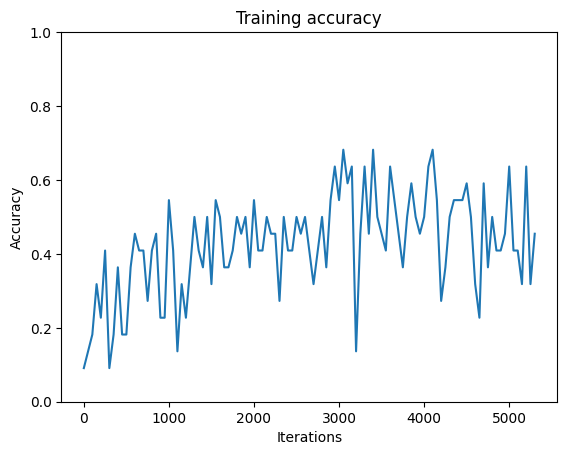

In [45]:
# training on entire dataset
train_logistic_model = MultiLogisticRegressionModel(77 * 58 * 3, 6)
iterations, train_accuracies, test_accuracies = train_logistic_model.train(train_data + test_data)
plot_accuracy_curve(iterations, train_accuracies, "Training accuracy")

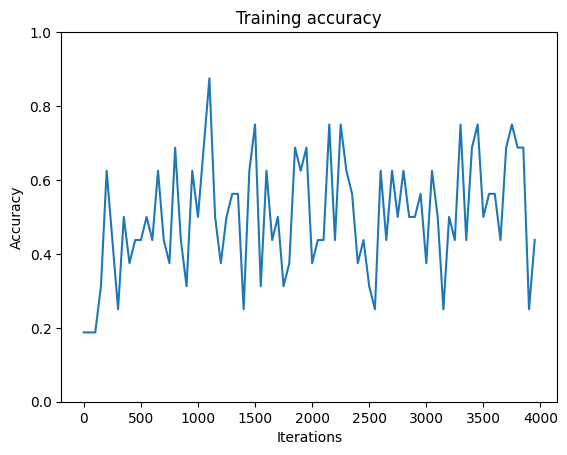

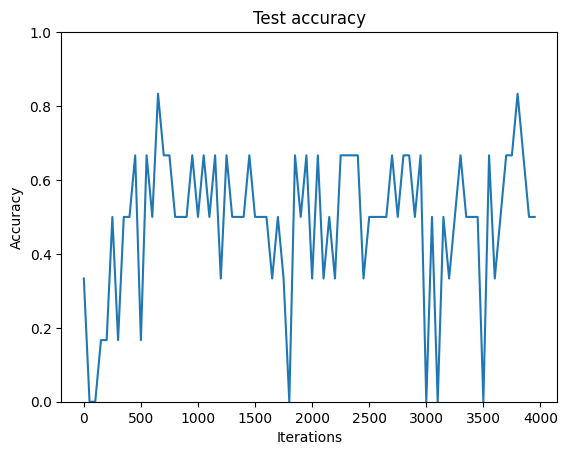

In [46]:
# test, train model with batch size 5
logistic_model = MultiLogisticRegressionModel(77 * 58 * 3, 6, 5)
iterations, train_accuracies, test_accuracies = logistic_model.train(train_data, test_data)
plot_accuracy_curve(iterations, train_accuracies, "Training accuracy")
plot_accuracy_curve(iterations, test_accuracies, "Test accuracy")

#     mnist_test.plot_confusion_matrix(train_logistic_model)

#     weights = train_logistic_model.get_weights()
#     for weight in weights:
#         weight.pop(0)
#         mnist_train.plot_image(weight)

In [48]:
def plot_confusion_matrix(dataset, model, step = 1, show_diagonal = False):
    confusion = [[0] * len(labels) for _ in labels]
    num_correct = 0
    num_evaluated = 0
    x, y = zip(*dataset)
    for i in range(0, get_size(dataset), step):
        class_prediction = model.predict(x[i])
        class_actual = y[i]
        num_correct += 1 if class_prediction == class_actual else 0
        num_evaluated += 1
        confusion[class_actual][class_prediction] += 1
    print("Accuracy:", num_correct / num_evaluated, '%  (', num_correct, 'out of', num_evaluated, ')')

    print("Confusion matrix:")
    print("  ", *subfolders)
    for k in range(len(labels)):
        print(subfolders[k], confusion[k])

    confusion_plot = confusion
    if not show_diagonal:
        for k in range(len(labels)):
            confusion_plot[k][k] = 0
    plt.imshow(confusion_plot)
    ax = plt.gca()
    ax.set_xticks(range(len(labels)), subfolders)
    ax.set_yticks(range(len(labels)), subfolders)
    ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
    plt.xlabel("Predicted class")
    ax.xaxis.set_label_position('top')
    plt.ylabel("Actual class")
    plt.title("Confusion matrix " + ("(including diagonal)" if show_diagonal else "(off-diagonal only)"))
    plt.colorbar()
    plt.show()

Accuracy: 0.503731343283582 %  ( 135 out of 268 )
Confusion matrix:
   cardboard glass metal paper plastic trash
cardboard [44, 0, 0, 0, 0, 0]
glass [3, 2, 12, 1, 29, 0]
metal [2, 1, 25, 0, 13, 6]
paper [13, 0, 1, 9, 25, 0]
plastic [1, 1, 4, 0, 41, 0]
trash [11, 0, 4, 0, 6, 14]


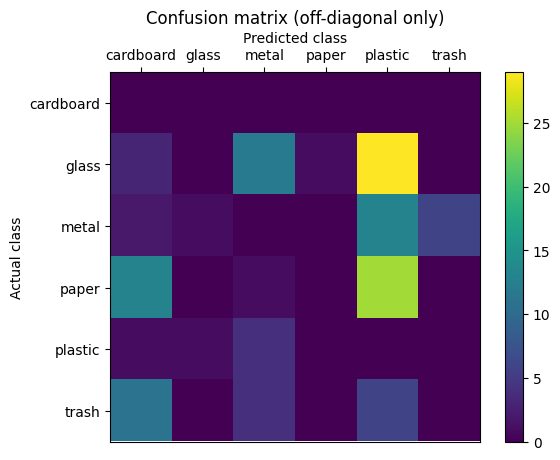

In [49]:
plot_confusion_matrix(test_data, logistic_model)